# <center> <font face=timenewroman color=yellow> LSTM Text Classification </center>

This project is about the analysis of tweets about chatgpt, with the goal of performing a Sentiment Analysis using LSTM and CNN algorithms to predict the emotion of a tweet (good, bad or Neutral).
Before feeding the data to the algorithm, the tweets will be deeply cleaned to remove links, hashtags at the end of the sentences and punctuation to allow the algorithms to better understand the text and improve the prediction performance.


## <center> <font face=timenewroman color=yellow> Link To Google Drive </center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## <center> <font face=timenewroman color=yellow> Importing required librarys </center>

In [ ]:
#@title ***Importing required librarys***

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
#@title ***Loading the dataset***

data = pd.read_csv("/content/drive/MyDrive/nlp-project/Dataset/file.csv")
data = data.drop([data.columns[0]], axis=1)
data.values[:5].tolist()

[['ChatGPT: Optimizing Language Models for Dialogue https://t.co/K9rKRygYyn @OpenAI',
  'neutral'],
 ['Try talking with ChatGPT, our new AI system which is optimized for dialogue. Your feedback will help us improve it. https://t.co/sHDm57g3Kr',
  'good'],
 ['ChatGPT: Optimizing Language Models for Dialogue https://t.co/GLEbMoKN6w #AI #MachineLearning #DataScience #ArtificialIntelligence\\n\\nTrending AI/ML Article Identified &amp; Digested via Granola; a Machine-Driven RSS Bot by Ramsey Elbasheer https://t.co/RprmAXUp34',
  'neutral'],
 ['THRILLED to share that ChatGPT, our new model optimized for dialog, is now public, free, and accessible to everyone. https://t.co/dyvtHecYbd https://t.co/DdhzhqhCBX https://t.co/l8qTLure71',
  'good'],
 ['As of 2 minutes ago, @OpenAI released their new ChatGPT. \\n\\nAnd you can use it right now 👇 https://t.co/VyPGPNw988 https://t.co/cSn5h6h1M1',
  'bad']]

## <center> <font face=timenewroman color=yellow> Drop duplicated values
 </center>

In [ ]:
print("Duplicated values: " , data.duplicated().sum())

data.drop_duplicates(inplace=True)
data = data.dropna(axis=0)
print(data.info())

Duplicated values:  1671
<class 'pandas.core.frame.DataFrame'>
Int64Index: 217623 entries, 0 to 219293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tweets  217623 non-null  object
 1   labels  217623 non-null  object
dtypes: object(2)
memory usage: 5.0+ MB
None


## <center> <font face=timenewroman color=yellow> Balancing Data

 </center>

In [ ]:
data["labels"].value_counts()

bad        106695
good        55754
neutral     55174
Name: labels, dtype: int64

In [ ]:
class_0 = data[data["labels"] == "neutral"]
class_1 = data[data["labels"] == "good"]
class_neg = data[data["labels"] == "bad"]
class_neg  = class_neg.iloc[:70000]
data = pd.concat([class_neg , class_0 , class_1])

data.head()

,tweets,labels
4,"As of 2 minutes ago, @OpenAI released their ne...",bad
6,"As of 2 minutes ago, @OpenAI released their ne...",bad
10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,bad
17,#ai Models are set to become the search engine...,bad
39,Google is done.\n\nCompare the quality of thes...,bad


In [ ]:
data["labels"].value_counts()

bad        70000
good       55754
neutral    55174
Name: labels, dtype: int64

## <center> <font face=timenewroman color=yellow> Preprocessing dataset


 </center>

In [ ]:
#@title ***Cleaning the dataset***
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer,PorterStemmer

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
st = PorterStemmer()
lem = WordNetLemmatizer()

def is_alpha(word):
    for part in word.split('-'):
        if not part.isalpha():
            return False

    return True

def clean_dataset(text):
    text = re.sub(r'http\S+', '', text) # removing links
    text = re.sub(r'\\n', ' ', text) # removing \\n
    text = re.sub(r"\s*#\S+", "", text) # removing hash tags
    text = re.sub(r"\s*@\S+", "", text) # removing @
    text = text.lower()
    words = [word for word in word_tokenize(text) if is_alpha(word)]
    words = [lem.lemmatize(word) for word in words]

    words = [w for w in words if not w in stop_words]
    text = " ".join(words)

    return text.strip()

data.insert(len(data.columns)-1, "cleaned_tweets", data['tweets'].apply(clean_dataset))
data.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,tweets,cleaned_tweets,labels
4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad
6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,bad
10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,bad
17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,bad
39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,bad


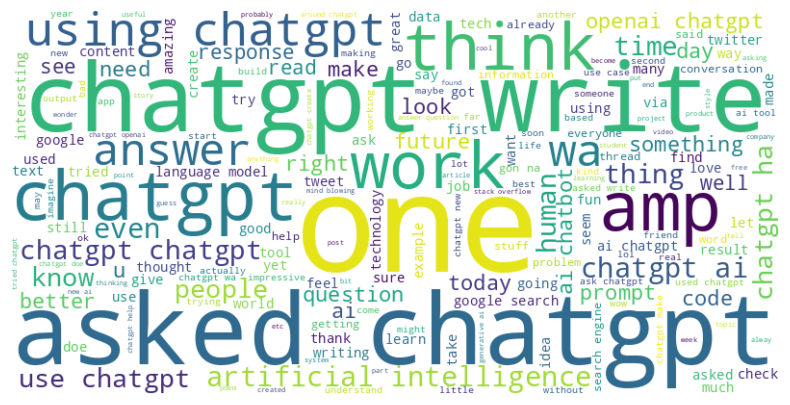

In [ ]:
# Create a text string from all the text
all_text = ' '.join(data['cleaned_tweets'])

# Create a WordCloud object with the desired settings
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display a WordCloud diagram using our prepared texts
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## <center> <font face=timenewroman color=yellow>Converting To Numerical



 </center>

In [ ]:
from numpy.core import numeric
#@title ***Converting text to numerical form***

import math
import collections

def convert_text_to_numerical(text):
    num_words = 7000
    tokenizer = Tokenizer(num_words=num_words)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    maxlen = 140


    pad_seqs = pad_sequences(sequences, maxlen=maxlen)
    pad_seqs_todrop = []
    for i, p in enumerate(pad_seqs):
        if sum(p) == sum(sorted(p, reverse=True)[0:2]):
            pad_seqs_todrop.append(i)

    return pad_seqs, pad_seqs_todrop, tokenizer, num_words, maxlen

data = data.reset_index()
numeric_tweets, rows_todrop, tokenizer, num_words, maxlen = convert_text_to_numerical(data['cleaned_tweets'])
data.insert(len(data.columns)-1, "numeric_tweets", numeric_tweets.tolist())
data.head()

,index,tweets,cleaned_tweets,numeric_tweets,labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad


In [ ]:
#@title ***Encoding output labels***

label_encoder = LabelEncoder()
data.insert(len(data.columns), "encoded_labels", label_encoder.fit_transform(data['labels']))
print(label_encoder.classes_)
data.head()

['bad' 'good' 'neutral']


,index,tweets,cleaned_tweets,numeric_tweets,labels,encoded_labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0


In [ ]:
final_data = data.drop(rows_todrop, inplace=False)
print(len(data), len(final_data))
final_data.head()

180928 167734


,index,tweets,cleaned_tweets,numeric_tweets,labels,encoded_labels
0,4,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
1,6,"As of 2 minutes ago, @OpenAI released their ne...",minute ago released new chatgpt use right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
2,10,GOD DAMN IT @OpenAI STOP ANNOUNCING THINGS I A...,god damn stop announcing thing busy,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
3,17,#ai Models are set to become the search engine...,model set become search engine future atm stil...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0
4,39,Google is done.\n\nCompare the quality of thes...,google done compare quality response chatgpt,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",bad,0


## <center> <font face=timenewroman color=yellow>Splitting Data: taining 80% and  testing 20%

 </center>

In [ ]:
#@title ***Splitting the dataset into training and testing sets***
inputs = final_data[['tweets', 'cleaned_tweets', 'numeric_tweets']]
outputs = final_data[['labels', 'encoded_labels']]

in_train, in_test, out_train, out_test = train_test_split(inputs, outputs, test_size=0.2, shuffle=True, random_state=42)

X_train = in_train['numeric_tweets']
X_test = in_test['numeric_tweets']
y_train = out_train['encoded_labels']
y_test = out_test['encoded_labels']

In [ ]:
X_train = np.asarray(X_train.tolist())
X_train = X_train.astype(np.int32)
X_test = np.asarray(X_test.tolist()).astype(np.int32)
y_train = np.asarray(y_train.tolist()).astype(np.int32)
y_test = np.asarray(y_test.tolist()).astype(np.int32)
type(X_train)

numpy.ndarray

In [ ]:
X_train

array([[   0,    0,    0, ...,  618,  106,  407],
       [   0,    0,    0, ...,   46,    2, 2489],
       [   0,    0,    0, ...,  949, 5749,   31],
       ...,
       [   0,    0,    0, ...,  104,  314,  178],
       [   0,    0,    0, ..., 1108, 1815,   20],
       [   0,    0,    0, ...,  195,  479,   46]], dtype=int32)

## <center> <font face=timenewroman color=yellow>Cnn Model
 </center>

In [ ]:
#@title ***Building the CNN model and train it***
from keras.callbacks import EarlyStopping
model1 = Sequential()
model1.add(Embedding(input_dim=num_words,output_dim=128, input_length=maxlen , trainable = True))

model1.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model1.add(MaxPooling1D(pool_size=2))
model1.add(Flatten())
model1.add(Dense(64, activation='relu'))
model1.add(Dense(3, activation='softmax'))

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(X_train, y_train, epochs=10, batch_size=1024, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.1)])

Epoch 1/10
118/118 [==============================] - 40s 239ms/step - loss: 0.7438 - accuracy: 0.6636 - val_loss: 0.4664 - val_accuracy: 0.8257
Epoch 2/10
118/118 [==============================] - 15s 131ms/step - loss: 0.3953 - accuracy: 0.8656 - val_loss: 0.3718 - val_accuracy: 0.8767
Epoch 3/10
118/118 [==============================] - 11s 91ms/step - loss: 0.3212 - accuracy: 0.8984 - val_loss: 0.3554 - val_accuracy: 0.8833
Epoch 4/10
118/118 [==============================] - 9s 76ms/step - loss: 0.2845 - accuracy: 0.9131 - val_loss: 0.3565 - val_accuracy: 0.8850
Epoch 5/10
118/118 [==============================] - 6s 54ms/step - loss: 0.2506 - accuracy: 0.9250 - val_loss: 0.3621 - val_accuracy: 0.8845
Epoch 6/10
118/118 [==============================] - 4s 37ms/step - loss: 0.2174 - accuracy: 0.9374 - val_loss: 0.3813 - val_accuracy: 0.8779


In [ ]:
#@title ***Measuring the model***

def get_measurements(true_y, pred_y, average='micro'):
    return {
      "accuracy": accuracy_score(true_y, pred_y),
      "recall": recall_score(true_y, pred_y, average=average),
      "precision": precision_score(true_y, pred_y, average=average),
      "fscore": f1_score(true_y, pred_y, average=average),
  }
predicted_labels = model1.predict(X_test, verbose=1)
get_measurements(y_test,  np.argmax(predicted_labels, axis=1))

1049/1049 [==============================] - 3s 3ms/step


{'accuracy': 0.8769785673830744,
 'recall': 0.8769785673830744,
 'precision': 0.8769785673830744,
 'fscore': 0.8769785673830744}

In [ ]:
#@title ***Cnn Prediction***
def predict_user_input(tweets , model):
    data = pd.DataFrame({ 'Tweets': tweets })
    cleaned_data = data['Tweets'].apply(clean_dataset)
    sequences = tokenizer.texts_to_sequences(cleaned_data)
    pad_seqs = pad_sequences(sequences, maxlen=maxlen)
    predicted_labels = model.predict(pad_seqs)
    data['labels'] = [ label_encoder.classes_[label_num] for label_num in np.argmax(predicted_labels, axis=1)]
    #print(data)
    return predicted_labels, data


predict_user_input([
    'chatgpt is very crazy !',
    'chatgpt is kind a dangerous',
    'woooow, chatgt is really impressive !!!',
    "chatgpt is an AI tool",
    "good results"] , model1)

predict_user_input([
    "The worst result, I did not expect that unwanted results. it is a useless tool",
    "my name is ahmed i want to became a data scientist",
    'woooow, chatgt is really impressive i can not imagine how chatgpt generate solution like humans  ',
    "chatgpt is an AI helpful tool to help solve complex problems and take less time than traditional way i like it",
    "good results when i use this tool i like it and it helped me and better than google"
] , model1)

1/1 [==============================] - 0s 36ms/step


(array([[9.99914527e-01, 2.06329041e-05, 6.47972411e-05],
        [2.04721123e-01, 1.08300755e-02, 7.84448743e-01],
        [1.50529842e-04, 9.99826968e-01, 2.25168696e-05],
        [6.39052037e-03, 9.48576987e-01, 4.50324863e-02],
        [1.39605108e-04, 9.99579489e-01, 2.80880631e-04]], dtype=float32),
                                               Tweets   labels
 0  The worst result, I did not expect that unwant...      bad
 1  my name is ahmed i want to became a data scien...  neutral
 2  woooow, chatgt is really impressive i can not ...     good
 3  chatgpt is an AI helpful tool to help solve co...     good
 4  good results when i use this tool i like it an...     good)

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

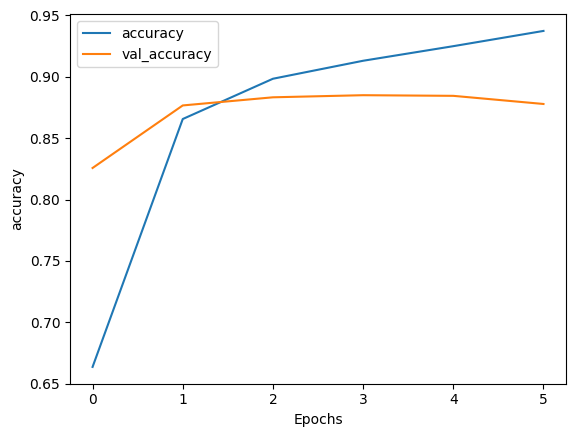

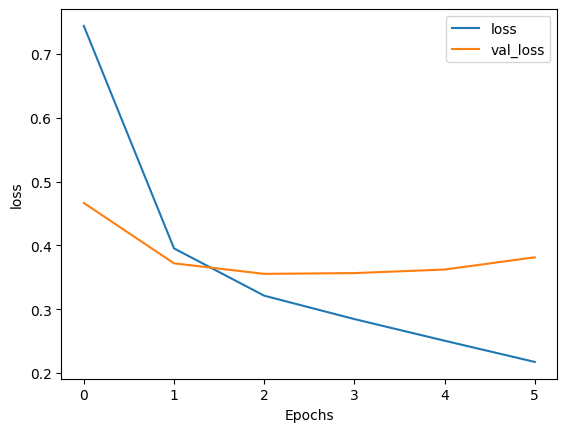

In [ ]:
plot_graphs(history1, "accuracy")
plot_graphs(history1, "loss")

## <center> <font face=timenewroman color=yellow>Lstm Model
 </center>

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

# Tokenize the input text
tokenizer = Tokenizer(num_words=7000)
tokenizer.fit_on_texts(data["tweets"])


# Pad the sequences to a fixed length
max_len = 140

## <center> <font face=timenewroman color=yellow>Word Embeding
 </center>

In [ ]:
from keras.utils import to_categorical

# Load pre-trained word embeddings
embedding_dim = 100
embeddings_index = {}
with open('/content/drive/MyDrive/nlp-project/Dataset/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Create an embedding matrix for the tokenizer
word_index = tokenizer.word_index
#num_words = min(len(word_index), 7000)
num_words =  7000
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Convert the output labels to one-hot encoded vectors
y_train_en = to_categorical(y_train)
y_test_en = to_categorical(y_test)

## <center> <font face=timenewroman color=yellow>Training model
 </center>

In [ ]:
# Create the model
model2 = Sequential()
model2.add(Embedding(num_words, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=True))
model2.add(LSTM(64, dropout=0.3, recurrent_dropout=0.3))
model2.add(Dense(3, activation='softmax'))


# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train, y_train_en, epochs=10, batch_size=1024, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

Epoch 1/10
118/118 [==============================] - 166s 1s/step - loss: 0.9653 - accuracy: 0.5201 - val_loss: 0.7672 - val_accuracy: 0.6534
Epoch 2/10
118/118 [==============================] - 117s 996ms/step - loss: 0.6693 - accuracy: 0.7120 - val_loss: 0.5176 - val_accuracy: 0.7948
Epoch 3/10
118/118 [==============================] - 122s 1s/step - loss: 0.5056 - accuracy: 0.8032 - val_loss: 0.4377 - val_accuracy: 0.8391
Epoch 4/10
118/118 [==============================] - 128s 1s/step - loss: 0.4358 - accuracy: 0.8363 - val_loss: 0.3912 - val_accuracy: 0.8621
Epoch 5/10
118/118 [==============================] - 126s 1s/step - loss: 0.3914 - accuracy: 0.8574 - val_loss: 0.3679 - val_accuracy: 0.8737
Epoch 6/10
118/118 [==============================] - 120s 1s/step - loss: 0.3608 - accuracy: 0.8729 - val_loss: 0.3531 - val_accuracy: 0.8808
Epoch 7/10
118/118 [==============================] - 105s 887ms/step - loss: 0.3416 - accuracy: 0.8812 - val_loss: 0.3377 - val_accuracy: 

## <center> <font face=timenewroman color=yellow>Testing model
 </center>

In [ ]:
def get_measurements(true_y, pred_y, average='micro'):
    return {
      "accuracy": accuracy_score(true_y, pred_y),
      "recall": recall_score(true_y, pred_y, average=average),
      "precision": precision_score(true_y, pred_y, average=average),
      "fscore": f1_score(true_y, pred_y, average=average),
  }

predicted_labels = model2.predict(X_test, verbose=1)
get_measurements(y_test,  np.argmax(predicted_labels, axis=1))

1049/1049 [==============================] - 62s 59ms/step


{'accuracy': 0.8913464691328584,
 'recall': 0.8913464691328584,
 'precision': 0.8913464691328584,
 'fscore': 0.8913464691328584}

In [ ]:
#@title ***Lstm Prediction***
print(predict_user_input([
    'chatgpt is very crazy !',
    'chatgpt is kind a dangerous',
    'woooow, chatgt is really impressive !!!',
    "chatgpt is an AI tool",
    "good results"] , model2))

print("")

print(predict_user_input([
    "The worst result, I did not expect that unwanted results. it is a useless tool",
    "my name is ahmed i want to became a data scientist",
    'woooow, chatgpt is really impressive i can not imagine how chatgpt generate solution like humans  ',
    "chatgpt is an AI helpful tool to help solve complex problems and take less time than traditional way i like it",
    "good results when i use this tool i like it and it helped me and better than google"
] , model2) )

print("finished")

1/1 [==============================] - 0s 65ms/step
(array([[0.00355236, 0.956466  , 0.03998155],
       [0.98309636, 0.00384308, 0.01306065],
       [0.983519  , 0.00357575, 0.01290525],
       [0.01574713, 0.00629665, 0.9779562 ],
       [0.96852064, 0.00455041, 0.02692899]], dtype=float32),                                     Tweets   labels
0                  chatgpt is very crazy !     good
1              chatgpt is kind a dangerous      bad
2  woooow, chatgt is really impressive !!!      bad
3                    chatgpt is an AI tool  neutral
4                             good results      bad)

1/1 [==============================] - 0s 64ms/step
(array([[0.88974637, 0.00723961, 0.10301396],
       [0.9922504 , 0.00114059, 0.00660902],
       [0.9811493 , 0.00269327, 0.01615733],
       [0.00104808, 0.9867459 , 0.01220606],
       [0.9688765 , 0.00343505, 0.02768848]], dtype=float32),                                               Tweets labels
0  The worst result, I did not expec

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

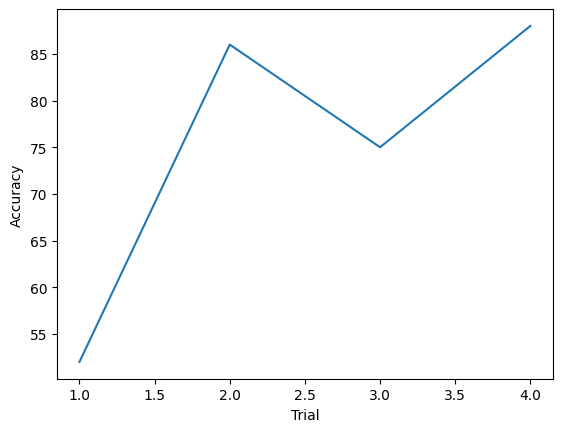

In [ ]:
#x = [1 , 2 , 3 , 4]
x= np.array([1, 2 , 3 ,  4])
y = [52 , 86 , 75 , 88]
y= np.array([52 , 86 , 75 , 88])
#plt.plot(x)
plt.plot(x,y)

plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.show()

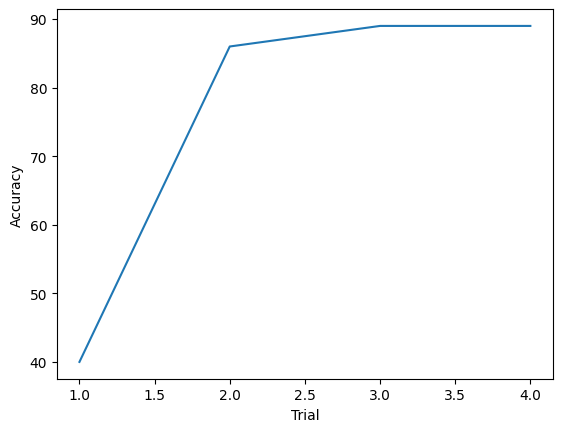

In [ ]:
x = [1 , 2 , 3 , 4]
y = [40 ,  86  , 89, 89]
#plt.plot(x)
plt.plot(x,y)

plt.xlabel("Trial")
plt.ylabel("Accuracy")
plt.show()

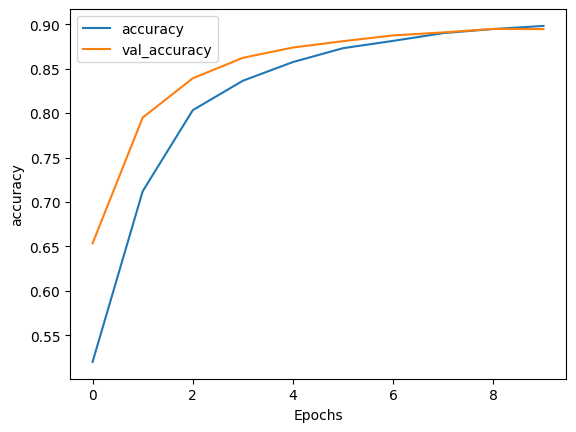

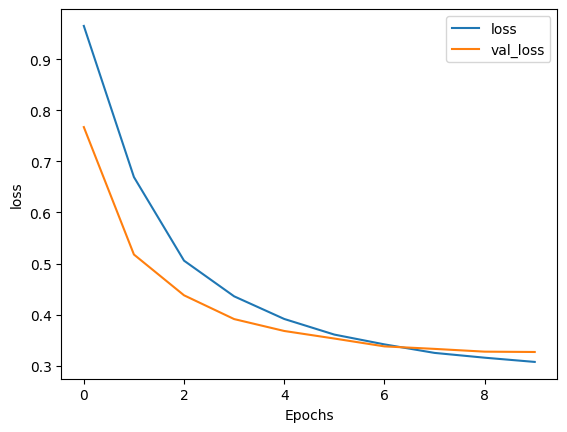

In [ ]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")